In [38]:
import sys
import os
sys.path.append('../')
from data_loader import DataLoader
import random
from feature_selector import BaselineSelector
from feature_selector import AnalysisSelector
from feature_selector import FeatureExtractor
from utils import parse_config_features
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import configparser
import re

#### all channels

In [39]:
config = configparser.ConfigParser()
config.read('../config.ini')

# all features of one epoch
X = pd.read_csv(os.path.join('..', config['Data']['features_path']))
# labels of one epoch
y = np.load(os.path.join('..', config['Data']['labels_path']))
# participant ids of one epoch
participants = np.load(os.path.join('..', config['Data']['par_ids_path']))

# drop ids
X = X.drop(X.columns[0], axis=1)
# append participants labels to find means per person
X['participant'] = participants
X['label'] = y

In [40]:
means = X.groupby(['participant', 'label']).mean()

In [41]:
cols = list(means.columns)

In [42]:
C_participants = means.loc[means.index.get_level_values('label') == 0]
A_participants = means.loc[means.index.get_level_values('label') == 1]
B_participants = means.loc[means.index.get_level_values('label') == 2]

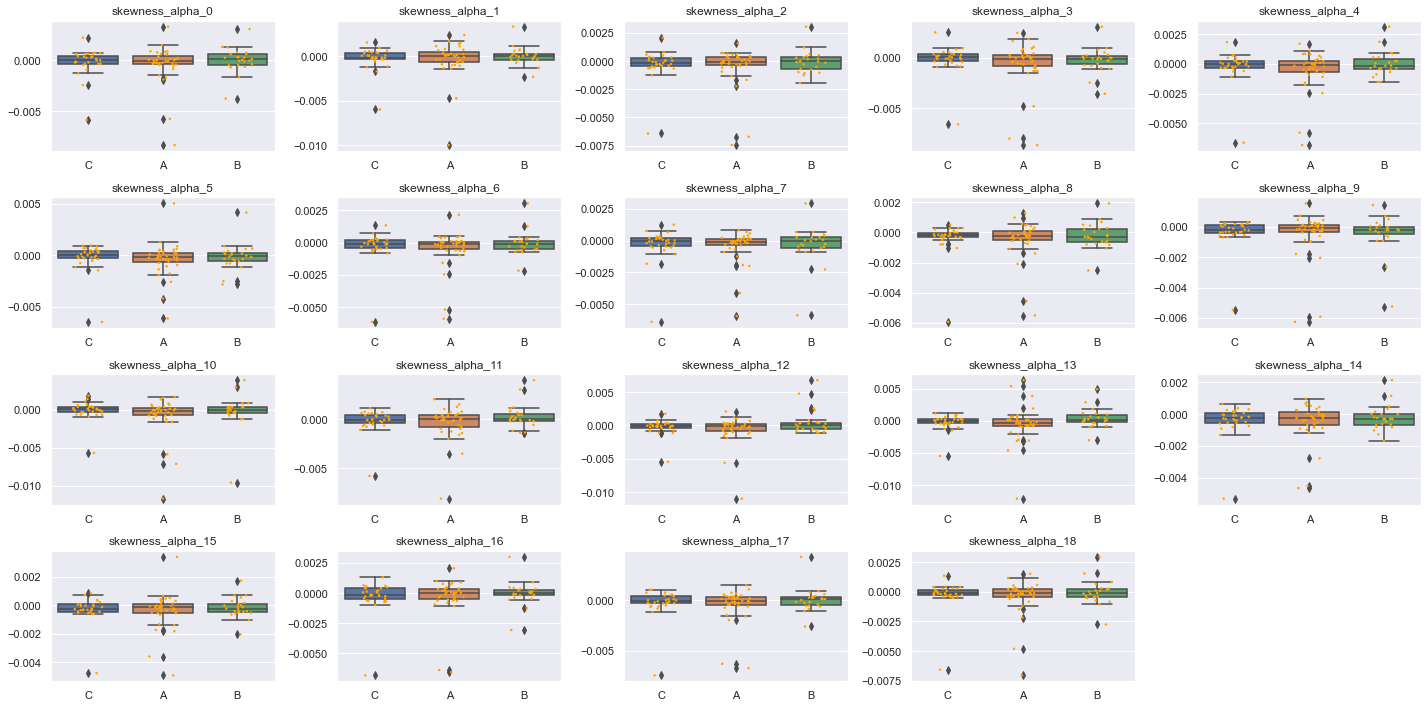

In [29]:
#set style and figure size
sns.set(rc = {'figure.figsize':(20,10)})
sns.set(style = "darkgrid")
plt.rcParams["figure.autolayout"] = True

27 jul 4 avg
23 30 avgf

for charac in range(25):
    f, axes = plt.subplots(4, 5)
    ax_last = axes[3][4]

    col = stop = charac*19
    for i in range(4):
        for j in range(5):
            # plot last subplot empty
            if col == stop + 19:
                ax_last.set_axis_off()
                break
            one_ch = {'C': list(C_participants[cols[col]]), 'A': list(A_participants[cols[col]]), 'B': list(B_participants[cols[col]])}
            #make dict same length by adding nan
            max_len = max([len(one_ch['C']), len(one_ch['A']), len(one_ch['B'])])
            for key in one_ch.keys():
                one_ch[key] += [np.nan]*(max_len-len(one_ch[key]))
            one_ch_df = pd.DataFrame(one_ch)

            #plot the boxplot and stripplot
            ax = sns.boxplot(data = one_ch_df, ax=axes[i][j])
            ax = sns.stripplot(data = one_ch_df, color="orange", jitter=0.2, size=2.5, ax=axes[i][j])
            ax.set_title(cols[col])
            #set y limits
            #ax.set_ylim(-5, 80)
            #ax = sns.violinplot(data = data_ch) 
            col += 1


    f.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig('../BoxPlotsAllFeatures/' + cols[stop][:-len(cols[stop].split('_')[-1])-1] + '.png', dpi = 300)
    plt.show()
    break
    

#### PCA on features

In [108]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(means)
X_pca = pca.transform(means)

In [109]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df['label'] = means.index.get_level_values('label')
X_pca_df['participant'] = means.index.get_level_values('participant')

In [110]:
C_participants = X_pca_df.loc[X_pca_df['label'] == 0]
A_participants = X_pca_df.loc[X_pca_df['label'] == 1]
B_participants = X_pca_df.loc[X_pca_df['label'] == 2]

In [111]:
cols = list(X_pca_df.columns)

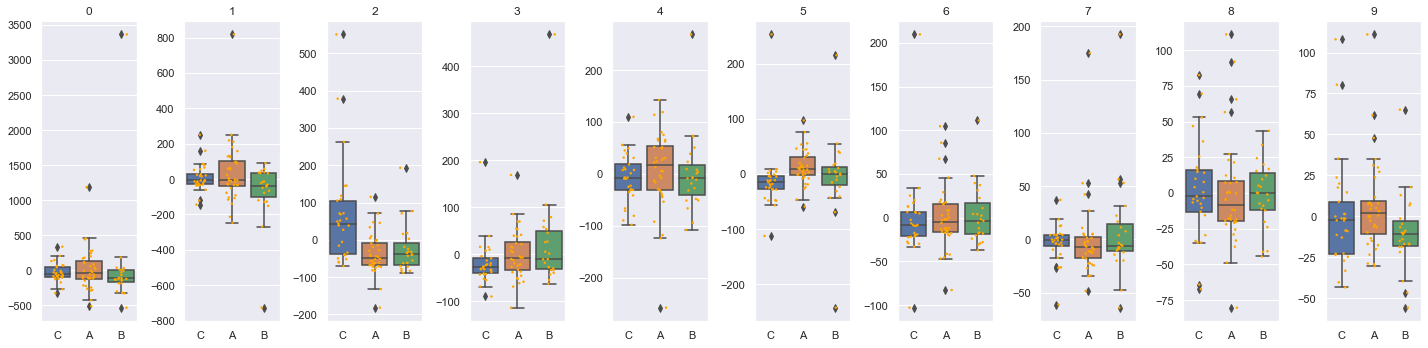

In [113]:
#set style and figure size
sns.set(rc = {'figure.figsize':(20,5)})
sns.set(style = "darkgrid")
plt.rcParams["figure.autolayout"] = True

col = 0

f, axes = plt.subplots(1,n_components)


for j in range(n_components):
    
    one_ch = {'C': list(C_participants[cols[col]]), 'A': list(A_participants[cols[col]]), 'B': list(B_participants[cols[col]])}
    #make dict same length by adding nan
    max_len = max([len(one_ch['C']), len(one_ch['A']), len(one_ch['B'])])
    for key in one_ch.keys():
        one_ch[key] += [np.nan]*(max_len-len(one_ch[key]))
    one_ch_df = pd.DataFrame(one_ch)

    #plot the boxplot and stripplot
    ax = sns.boxplot(data = one_ch_df, ax=axes[j])
    ax = sns.stripplot(data = one_ch_df, color="orange", jitter=0.2, size=2.5, ax=axes[j])
    ax.set_title(cols[col])
    #set y limits
    #ax.set_ylim(-5, 80)
    #ax = sns.violinplot(data = data_ch) 
    col += 1


f.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../BoxPlotsPCA/' + str(cols[0]) + '.png', dpi = 300)
plt.show()
  

## Old code for PCA performed on all channels 

### Analysis of a signle channel

In [35]:
# file path to our dataset to all epoches of all participants
data_path = "../data/dataset"

# create a data loader for all participants
par_loaders = [0] * 88
for i in range(88):
    par_loaders[i] = DataLoader(data_path, [i])

# returns all data of all epochs for participant one 
participants = par_loaders[0][:]
# returns data of the first epoch for participant one for all channels
participant1 = participants[0]['data']

In [36]:
selector1 = BaselineSelector()
selector2 = AnalysisSelector()
selector1.selectFeatures(['kurtosis'])
selector2.selectFeatures(['hjorth_activity', 'band_power_alpha'])

channel_means_A = {}
channel_means_C = {}
channel_means_F = {}
for channel in range(19):
    channel_means_A[channel] = []
    channel_means_C[channel] = []
    channel_means_F[channel] = []

In [37]:
for participant in par_loaders:
    x = {}
    for channel in range(19):
        x[channel] = []
    
    for epoch in participant[:]:
        epoch_data = epoch['data']
        out1 = selector2.transform(epoch_data)
        
        for channel in range(19):
            x[channel].append(out1['hjorth_activity'][channel])
    
    for channel in range(19):
        if participant[0]['group'] == 'A':
            channel_means_A[channel].append(np.mean(x[channel]))
        elif participant[0]['group'] == 'C':
            channel_means_C[channel].append(np.mean(x[channel]))
        elif participant[0]['group'] == 'F':
            channel_means_F[channel].append(np.mean(x[channel]))
    

KeyboardInterrupt: 

In [ ]:
channel_means_A_df = pd.DataFrame(channel_means_A)
channel_means_C_df = pd.DataFrame(channel_means_C)
channel_means_F_df = pd.DataFrame(channel_means_F)

In [ ]:
ch = 7
data_ch = {}
data_ch = pd.DataFrame({'A': channel_means_A_df[ch], 'C': channel_means_C_df[ch], 'F': channel_means_F_df[ch]})

In [ ]:
#set style and figure size
sns.set(rc={'figure.figsize':(10,6)})
sns.set(style="darkgrid")

#plot the boxplot and stripplot
ax = sns.boxplot(data = data_ch)
ax = sns.stripplot(data=data_ch, color="orange", jitter=0.2, size=2.5)
#ax = sns.violinplot(data = data_ch) 

#set title and axis labels
ax.set(xlabel='group', ylabel='activity', title='Hjorth param activity of alpha band of channel '+str(ch)+' for all groups')

#set y limits
#ax.set_ylim(-10, 40)

# adding transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.show()

### Analysis of 8 pca channels

In [ ]:
# file path to our dataset to all epoches of all participants
data_path = "../data/dataset"

# create a data loader for all participants
par_loaders = [0] * 88
for i in range(88):
    par_loaders[i] = DataLoader(data_path, [i])

# returns all data of all epochs for participant one 
participants = par_loaders[0][:]
# returns data of the first epoch for participant one for all channels
participant1 = participants[0]['data']

alz = 0
cont = 0
fam = 0
for participant in par_loaders:
    if participant[0]['group'] == 'A':
        alz += 1
    elif participant[0]['group'] == 'C':
        cont += 1
    elif participant[0]['group'] == 'F':
        fam += 1

print(alz, cont, fam)

36 29 23


In [ ]:
#mora niz nizova pa da se doda kurtosis tacno tog kanala u odg listu
features_A = {'kurtosis' : [[] for _ in range(8)], 'skewness' : [[] for _ in range(8)], 'band_power_alpha' : [[] for _ in range(8)], 'band_power_beta' : [[] for _ in range(8)], \
    'band_power_gamma' : [[] for _ in range(8)], 'band_power_delta' : [[] for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [[] for _ in range(8)], 'hjorth_mobility' : [[] for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}
features_C = {'kurtosis' : [[] for _ in range(8)], 'skewness' : [[] for _ in range(8)], 'band_power_alpha' : [[] for _ in range(8)], 'band_power_beta' : [[] for _ in range(8)], \
    'band_power_gamma' : [[] for _ in range(8)], 'band_power_delta' : [[] for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [[] for _ in range(8)], 'hjorth_mobility' : [[] for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}
features_F = {'kurtosis' : [[] for _ in range(8)], 'skewness' : [[] for _ in range(8)], 'band_power_alpha' : [[] for _ in range(8)], 'band_power_beta' : [[] for _ in range(8)], \
    'band_power_gamma' : [[] for _ in range(8)], 'band_power_delta' : [[] for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [[] for _ in range(8)], 'hjorth_mobility' : [[] for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}

selector = AnalysisSelector()
selector.selectFeatures(['kurtosis', 'skewness', 'band_power_alpha', 'band_power_beta', 'band_power_delta', 'band_power_theta', 'band_power_gamma', 'hjorth_activity', 'hjorth_mobility', 'hjorth_complexity'], pca_components = 8)

for person in par_loaders:

    temp_A = {'kurtosis' : [0 for _ in range(8)], 'skewness' : [0 for _ in range(8)], 'band_power_alpha' : [0 for _ in range(8)], 'band_power_beta' : [0 for _ in range(8)], \
        'band_power_gamma' : [0 for _ in range(8)], 'band_power_delta' : [0 for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [0 for _ in range(8)], 'hjorth_mobility' : [0 for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}
    temp_C = {'kurtosis' : [0 for _ in range(8)], 'skewness' : [0 for _ in range(8)], 'band_power_alpha' : [0 for _ in range(8)], 'band_power_beta' : [0 for _ in range(8)], \
        'band_power_gamma' : [0 for _ in range(8)], 'band_power_delta' : [0 for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [0 for _ in range(8)], 'hjorth_mobility' : [0 for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}
    temp_F = {'kurtosis' : [0 for _ in range(8)], 'skewness' : [0 for _ in range(8)], 'band_power_alpha' : [0 for _ in range(8)], 'band_power_beta' : [0 for _ in range(8)], \
        'band_power_gamma' : [0 for _ in range(8)], 'band_power_delta' : [0 for _ in range(8)], 'band_power_theta' : [[] for _ in range(8)], 'hjorth_activity' : [0 for _ in range(8)], 'hjorth_mobility' : [0 for _ in range(8)], 'hjorth_complexity' : [[] for _ in range(8)]}
        
    all_epochs = person[:]
    for epoch in all_epochs:
        epoch_data = epoch['data']

        out = selector.transform(epoch_data)

        if(epoch['group'] == 'A'):
            for key, value in temp_A.items():
                temp_A[key] = [x + y for x, y in zip(temp_A[key], out[key])]
        elif(epoch['group'] == 'C'):
            for key, value in temp_C.items():
                temp_C[key] = [x + y for x, y in zip(temp_C[key], out[key])]
        elif(epoch['group'] == 'F'):
            for key, value in temp_F.items():
                temp_F[key] = [x + y for x, y in zip(temp_F[key], out[key])]

    if(all_epochs[0]['group'] == 'A'):
        for key, value in temp_A.items():
            temp_A[key] = [x / len(all_epochs) for x in temp_A[key]]
        for key, value in temp_A.items():
            for i in range(8):
                features_A[key][i].append(temp_A[key][i])
    elif(all_epochs[0]['group'] == 'C'):
        for key, value in temp_C.items():
            temp_C[key] = [x / len(all_epochs) for x in temp_C[key]]
        for key, value in temp_C.items():
            for i in range(8):
                features_C[key][i].append(temp_C[key][i])
    elif(all_epochs[0]['group'] == 'F'):
        for key, value in temp_F.items():
            temp_F[key] = [x / len(all_epochs) for x in temp_F[key]]
        for key, value in temp_F.items():
            for i in range(8):
                features_F[key][i].append(temp_F[key][i])

In [ ]:
keys = ['kurtosis', 'skewness', 'band_power_alpha', 'band_power_beta', 'band_power_gamma', 'band_power_theta', 'band_power_delta', 'hjorth_activity', 'hjorth_mobility', 'hjorth_complexity']
key = 3
# ch = 0
df_A = pd.DataFrame(features_A[keys[key]]).T
df_C = pd.DataFrame(features_C[keys[key]]).T
df_F = pd.DataFrame(features_F[keys[key]]).T

# data_ch = pd.DataFrame({'A': df_A[ch], 'C': df_C[ch], 'F': df_F[ch]})
data_ch = pd.DataFrame({'A_0': df_A[0], 'C_0': df_C[0], 'F_0': df_F[0], 'A_1': df_A[1], 'C_1': df_C[1], 'F_1': df_F[1], 'A_2': df_A[2], 'C_2': df_C[2], 'F_2': df_F[2], 'A_3': df_A[3], 'C_3': df_C[3], 'F_3': df_F[3], 'A_4': df_A[4], 'C_4': df_C[4], 'F_4': df_F[4], 'A_5': df_A[5], 'C_5': df_C[5], 'F_5': df_F[5], 'A_6': df_A[6], 'C_6': df_C[6], 'F_6': df_F[6], 'A_7': df_A[7], 'C_7': df_C[7], 'F_7': df_F[7]})

In [ ]:
#set style and figure size
sns.set(rc = {'figure.figsize':(20,10)})
sns.set(style = "darkgrid")
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(2, 4)

channel = 0
for i in range(2):
    for j in range(4):
        #plot the boxplot and stripplot
        ax = sns.boxplot(data = data_ch[[f'A_{channel}', f'C_{channel}', f'F_{channel}']], ax=axes[i][j])
        ax = sns.stripplot(data = data_ch[[f'A_{channel}', f'C_{channel}', f'F_{channel}']], color="orange", jitter=0.2, size=2.5, ax=axes[i][j])
        #ax = sns.violinplot(data = data_ch) 

        channel += 1

#set title of the whole figure
f.suptitle(keys[key] + ' of 8 PCA channels ' + ' for all groups')

#set y limits
#ax.set_ylim(-10, 10)

f.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../BoxPlotsPCA/'+keys[key]+'.png', dpi = 300)
plt.show()